In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
%matplotlib inline
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
data_path = os.path.join("./", "./data/", "modified_dataset.csv")

try:
    df=pd.read_csv(data_path)
    df.head()
except Exception as e:
    print("File Can't be loaded", e)

In [4]:
categorical_columns = ['source_prefix', 'dest_prefix', 'agent', 'status', 'hour']
df_m = pd.get_dummies(df, columns=categorical_columns)
df_m.head()

,amount,label,source_prefix_Bacon,source_prefix_Beanie,source_prefix_Biscuit,source_prefix_Boomer,source_prefix_Bubbles,source_prefix_Cheesepuff,source_prefix_Chuckles,source_prefix_Dizzy,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1000000,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,50000000,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,2000000,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,9110000,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,1000000,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [5]:
df_m= df_m.astype(int)

In [15]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold,train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler

In [16]:
# Split the data using Stratified Splitting
X = df_m.drop('label', axis=1)
y = df_m['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [20]:
# Apply SMOTE only on training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [21]:
# Scale the data
scaler = StandardScaler()
X_train_resampled['amount'] = scaler.fit_transform(X_train_resampled[['amount']])
X_test['amount'] = scaler.transform(X_test[['amount']])

In [22]:
# Apply XGBClassifier with GridSearchCV for hyperparameter tuning
xgb_clf = xgb.XGBClassifier(random_state=42)

In [23]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [24]:
# Perform GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='f1')

In [25]:
# Get the best model
best_xgb = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [26]:
y_test_probs = best_xgb.predict_proba(X_test)[:, 1]

In [27]:
# Set threshold based on fraud rate of 3.5%
threshold = 0.035

In [28]:
y_test_pred_threshold = (y_test_probs > threshold).astype(int)

In [29]:
# Evaluate model on training and testing data
precision = precision_score(y_test, y_test_pred_threshold)
recall = recall_score(y_test, y_test_pred_threshold)
f1 = f1_score(y_test, y_test_pred_threshold)
accuracy = accuracy_score(y_test, y_test_pred_threshold)
roc_auc = roc_auc_score(y_test, y_test_probs)

In [30]:
# Print results
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')

Precision: 0.13720838275998418
Recall: 0.9416553595658074
F1 Score: 0.23951682484900777
Accuracy: 0.7922010562052055
ROC AUC: 0.9463469088581278


In [31]:
conf_matrix = confusion_matrix(y_test, y_test_pred_threshold)
print(f'Confusion Matrix:\n{conf_matrix}')

Confusion Matrix:
[[16107  4364]
 [   43   694]]


In [32]:
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

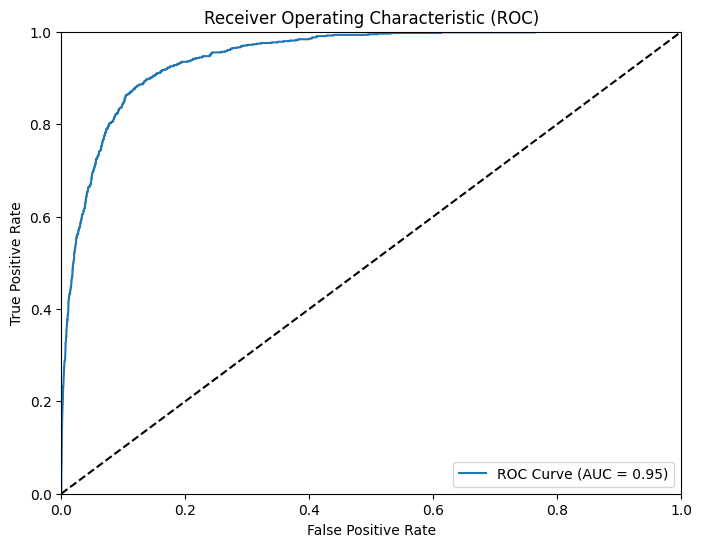

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

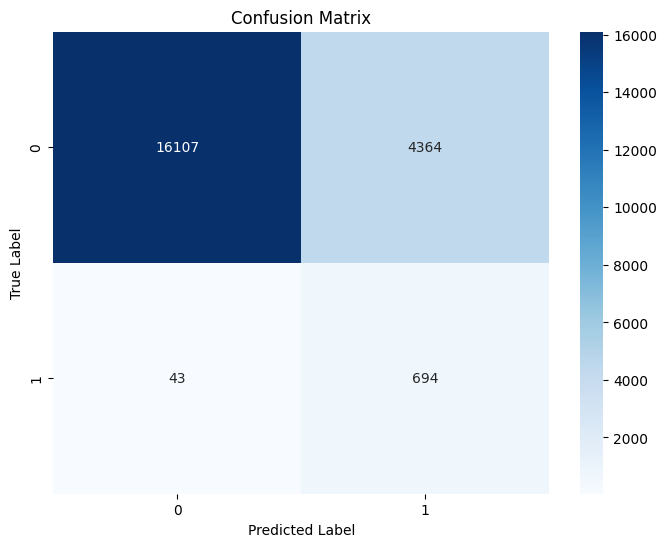

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### The XGBoost model for fraud detection shows the following performance metrics:
### Precision: 0.1372 (13.72%)
### This indicates that 13.72% of the instances predicted as fraud were actually fraudulent. While better than the KMeans model, it still suggests a high number of false positives.
### Recall: 0.9417 (94.17%)
### The recall value is very high, showing that the model correctly identified 94.17% of all actual fraudulent cases. This is a significant improvement over the KMeans model.
### F1-Score: 0.2395 (23.95%)
### The F1-score, while low, is much better than the KMeans model. It indicates a better balance between precision and recall.
### Accuracy: 0.7922 (79.22%)
### The overall accuracy of the model is 79.22%, which is relatively good considering the imbalanced nature of fraud detection problems.
### ROC AUC: 0.9463 (94.63%)
### This high AUC value indicates that the model has a very good ability to distinguish between fraudulent and non-fraudulent transactions.
### Confusion Matrix:
### The confusion matrix shows that the model correctly identified a large number of non-fraudulent transactions (TN) and most of the fraudulent ones (TP). However, it also misclassified a significant number of non-fraudulent transactions as fraudulent (FP).
### Overall, the XGBoost model performs significantly better than the KMeans model. It shows excellent recall and AUC, indicating a strong ability to identify fraudulent transactions. However, the low precision suggests that the model tends to overpredict fraud, which could lead to a high number of false alarms. Depending on the specific requirements of the fraud detection system, this model might be considered acceptable, especially if detecting all potential fraud cases is prioritized over minimizing false positives.

In [4]:
joblib.dump(best_xgb, 'best_xgb_model.pkl')
print("Best XGBoost model saved as 'best_xgb_model.pkl'.")

NameError: name 'best_xgb' is not defined